In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm
import corner
import datetime

import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:

from agnfinder.tf_sampling.hmc import hmc

In [4]:
os.chdir('/home/walml/repos/agnfinder')

## Utilities

In [5]:
def is_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [7]:
def make_valid_covariance(x):
    x_sym = np.maximum( x, x.transpose() )
    assert is_symmetric(x_sym)
    assert is_pos_def(x_sym)
    return x_sym

## Distribution to Sample (without batch_dim)

In [186]:
# dist = tfd.MultivariateNormalDiag(
#       loc=[.3, .7],
#       scale_diag=[0.3, 0.3])
# dist.mean().numpy()

# two slightly overlapping 2D Gaussians
# components_distribution = tfd.MultivariateNormalDiag(
#     loc=[[.8, .5], [.2, .5]],
#     scale_diag=[[.2, .4], [.2, .4]])
# dist = tfd.MixtureSameFamily(
#     mixture_distribution=tfd.Categorical(
#         probs=[0.5, 0.5]),
#      components_distribution=components_distribution
# )

# one highly covariant ND gaussian
dim = 4
mu = [[0] * dim]
cov = np.eye(dim, dim)
cov[1, 0] = -.95
cov[0, 1] = -.95
cov_valid = make_valid_covariance(cov)
lower_tri_cov = tf.cast(tf.linalg.cholesky(cov_valid), tf.float32)
# print(lower_tri_cov)
true_dist = tfd.MultivariateNormalTriL(
    loc=mu,
    scale_tril=lower_tri_cov
)


In [14]:
true_dist.sample().shape

TensorShape([1, 4])

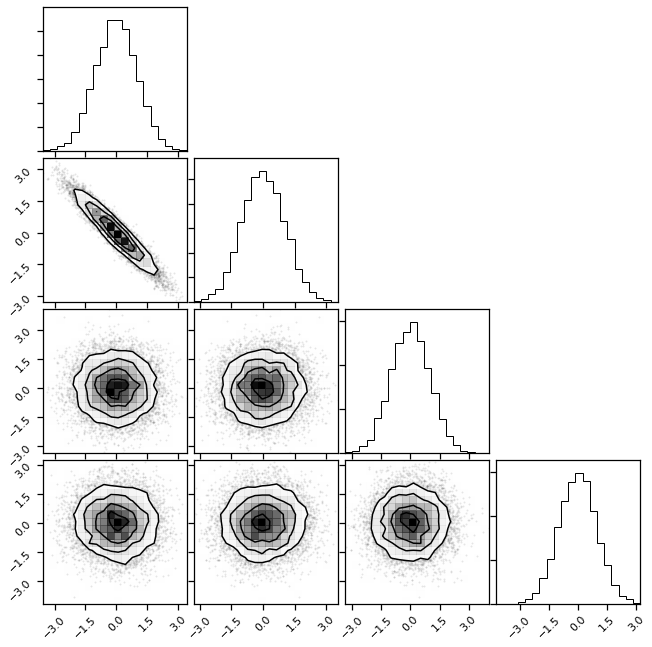

In [15]:
exact_samples = true_dist.sample(10000)
exact_samples.shape
_ = corner.corner(exact_samples.numpy().squeeze())

In [177]:
tfb = tfp.bijectors

nvp = tfb.RealNVP(
      num_masked=2,
      shift_and_log_scale_fn=tfb.real_nvp_default_template(
          hidden_layers=[512, 512]))


In [182]:
# A common choice for a normalizing flow is to use a Gaussian for the base
# distribution. (However, any continuous distribution would work.) E.g.,
nvp = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=[0., 0., 0.]),
    bijector=tfb.RealNVP(
        num_masked=2,
        shift_and_log_scale_fn=tfb.real_nvp_default_template(
            hidden_layers=[512, 512])))

x = nvp.sample(1000)
# nvp.log_prob(x)
# nvp.log_prob(0.)


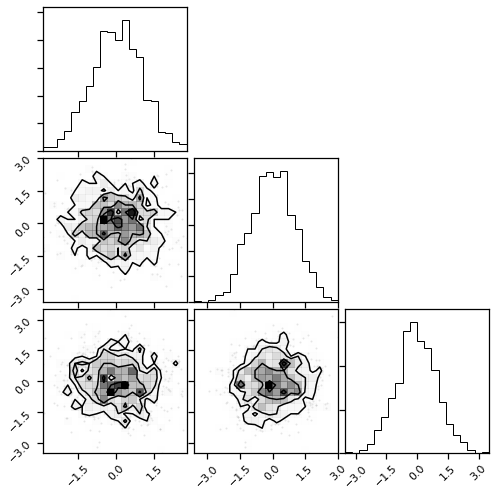

In [184]:
_ = corner.corner(x)

## using the (perfect) samples, estimate covariance

In [16]:
from sklearn.covariance import ShrunkCovariance, EmpiricalCovariance

emp_estimator = EmpiricalCovariance().fit(exact_samples.numpy().squeeze())

# https://scikit-learn.org/stable/modules/covariance.html
# Despite being an unbiased estimator of the covariance matrix, the Maximum Likelihood Estimator is not a good estimator of the eigenvalues of the covariance matrix, so the precision matrix obtained from its inversion is not accurate
shrunk_estimator = ShrunkCovariance().fit(exact_samples.numpy().squeeze())
print(np.array(cov_valid))
print()
print(np.around(emp_estimator.covariance_, 2))
print()
print(np.around(shrunk_estimator.covariance_, 2))  # puts upper limits on eigenvalues, to help with inversion - but not as good an estimate?

[[ 1.   -0.95  0.    0.  ]
 [-0.95  1.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]

[[ 1.01 -0.96 -0.02 -0.02]
 [-0.96  1.    0.02  0.02]
 [-0.02  0.02  1.    0.  ]
 [-0.02  0.02  0.    0.98]]

[[ 1.01 -0.86 -0.02 -0.02]
 [-0.86  1.    0.02  0.02]
 [-0.02  0.02  1.    0.  ]
 [-0.02  0.02  0.    0.98]]


In [19]:
# These already have precision matrices (i.e. inverses) calculated:
print(emp_estimator.precision_)
print()
print(shrunk_estimator.precision_)

[[ 1.00638233e+01  9.59826744e+00  5.41945724e-03 -1.06323680e-02]
 [ 9.59826744e+00  1.01503237e+01 -1.22341490e-02 -3.39443332e-02]
 [ 5.41945724e-03 -1.22341490e-02  1.00173957e+00 -1.56113190e-03]
 [-1.06323680e-02 -3.39443332e-02 -1.56113190e-03  1.02022745e+00]]

[[ 3.68708892e+00  3.16633709e+00  7.29362597e-03  4.01969805e-03]
 [ 3.16633709e+00  3.71558613e+00 -9.40800110e-03 -1.79420122e-02]
 [ 7.29362597e-03 -9.40800110e-03  1.00161376e+00 -1.42623926e-03]
 [ 4.01969805e-03 -1.79420122e-02 -1.42623926e-03  1.01817749e+00]]


Every symmetric, positive definite matrix A can be decomposed into a product of a unique lower triangular matrix L and its transpose.
L {\displaystyle L} is called the Cholesky factor of A {\displaystyle A} , and can be interpreted as a generalized square root of A {\displaystyle A}

In [139]:

log_prob = true_dist.log_prob
log_prob=tf.function(log_prob, experimental_compile=True)
 
n_chains = 2
# initial_state = tf.constant([0.1, 0.15, 0.2])
# initial_state = tf.constant(np.random.rand(n_chains, 3), dtype=tf.float32)
initial_state = tf.zeros((n_chains, dim), dtype=tf.float32)
num_results = 10
num_burnin = 5

In [94]:
log_prob(initial_state).numpy()

array([-2.5118027, -2.5118027], dtype=float32)

In [95]:
from agnfinder.tf_sampling.hmc import get_covariances, get_proposal_distributions

In [96]:
exact_samples.shape

TensorShape([10000, 1, 4])

In [97]:
covariances, inv_covariances = get_covariances(exact_samples)

In [98]:
# here we know it's all the same fundamental distribution, so just multiply across chains
proposal_distributions = get_proposal_distributions([inv_covariances[0] for _ in range(n_chains)])

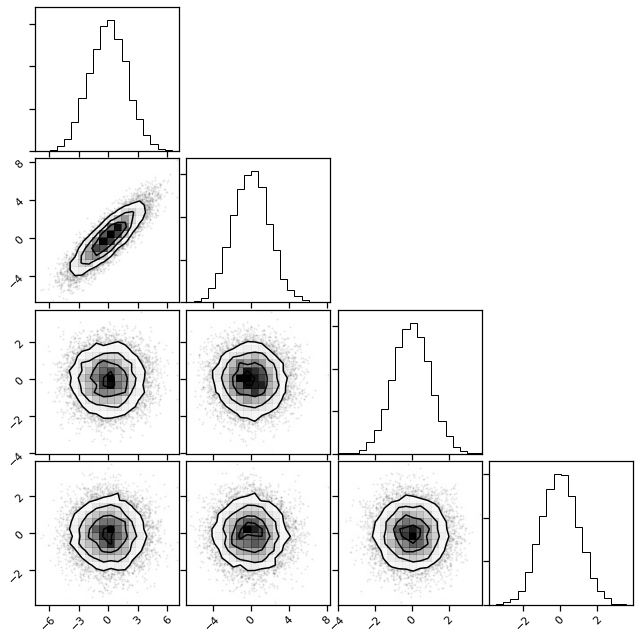

In [99]:
_ = corner.corner(proposal_distributions.sample(5000).numpy().reshape(-1, dim))

In [169]:
# initial_step_size = .1
# initial_step_sizes = tf.fill(initial_state.shape, initial_step_size) 
initial_step_sizes = 0.1 + tf.random.uniform([2, dim]) * 0.00000001  # used to show that while each chain has it's own step size, log_accept_prob is per chain so adaption across variables is identical
# coud use sigma observed in early stages (averaged across galaxies?) to scale per-var step sizes (which will then adapt in sync)
num_leapfrog_steps = 1  # about .1 step size at n=5
print(initial_step_sizes.shape)

# nuts_kernel = tfp.mcmc.NoUTurnSampler(
#     target_log_prob_fn=log_prob,
#     step_size=initial_step_sizes
# )
# step_size=tf.fill([n_chains, 2], step_size)  # should be same shape as initial_state for each chain to have own step size. Same step size per variable, though??

hmc_kernel_metric = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=num_leapfrog_steps,
    step_size=initial_step_sizes,
    proposal_distributions=proposal_distributions
)

hmc_kernel_normal = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=num_leapfrog_steps,
    step_size=initial_step_sizes,
    proposal_distributions=None
)



(2, 4)


In [173]:
hmc_adaptive_kernel_normal = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc_kernel_normal,
#     num_adaptation_steps=int(num_burnin + num_results/2)
    num_adaptation_steps=int(num_burnin * 0.8),
    
)

hmc_adaptive_kernel_metric = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc_kernel_metric,
#     num_adaptation_steps=int(num_burnin + num_results/2)
    num_adaptation_steps=int(num_burnin * 0.8),
    
)

# https://github.com/tensorflow/probability/issues/549
# nuts_adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
#     nuts_kernel,
#     num_adaptation_steps=int(num_burnin * 0.8),
#     step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
#     step_size_getter_fn=lambda pkr: pkr.step_size,
#     log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
# )

In [174]:
# initial_state.shape

In [175]:
def trace_fn(_, pkr):  # pkr = previous kernel results
    return (
        pkr.inner_results.log_accept_ratio,
        pkr.inner_results.accepted_results.target_log_prob,
        pkr.inner_results.accepted_results.step_size,
        pkr.inner_results.is_accepted
    )


In [188]:
start_time = datetime.datetime.now()

chain_output_normal= tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin,
    current_state=initial_state,
    kernel=hmc_adaptive_kernel_normal,
    trace_fn=trace_fn
)

time_elapsed = datetime.datetime.now() - start_time
print(f'HMC sampling complete in {time_elapsed}')
#     https://github.com/tensorflow/probability/blob/f90448698cc2a16e20939686ef0d5005aad95f29/tensorflow_probability/python/mcmc/nuts.py#L72
#     trace_fn=lambda _, prev_kernel_results: {'is_accepted': prev_kernel_results.inner_results.is_accepted, 'step_size': prev_kernel_results.inner_results.step_size}

HMC sampling complete in 0:00:00.175413


In [168]:
start_time = datetime.datetime.now()

chain_output_metric = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin,
    current_state=initial_state,
    kernel=hmc_adaptive_kernel_metric,
    trace_fn=trace_fn
)

time_elapsed = datetime.datetime.now() - start_time
print(f'HMC sampling complete in {time_elapsed}')
#     https://github.com/tensorflow/probability/blob/f90448698cc2a16e20939686ef0d5005aad95f29/tensorflow_probability/python/mcmc/nuts.py#L72
#     trace_fn=lambda _, prev_kernel_results: {'is_accepted': prev_kernel_results.inner_results.is_accepted, 'step_size': prev_kernel_results.inner_results.step_size}

[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.10161165, 0.10730049, 0.10925321, 0.10359675],
       [0.10820412, 0.10548186, 0.10955193, 0.10647438]], dtype=float32)>]
[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1.6006352, 1.6902485, 1.7210084, 1.6319051],
       [1.0169688, 0.9913832, 1.0296363, 1.0007118]], dtype=float32)>]
[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.31264225, 0.33014593, 0.33615407, 0.31875005],
       [0.17044859, 0.16616033, 0.17257172, 0.16772383]], dtype=float32)>]
[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.49211508, 0.5196667 , 0.5291239 , 0.5017291 ],
       [0.26069686, 0.25413808, 0.26394415, 0.25652942]], dtype=float32)>]
[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.05478918, 0.05785662, 0.05890952, 0.05585955],
       [0.21779723, 0.21231776, 0.22051013, 0.21431558]], dtype=float32)>]
[<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.18710314, 0.19757833, 0.20117396, 0.1907584 

In [106]:
# start_time = datetime.datetime.now()

# chain_output = tfp.mcmc.sample_chain(
#     num_results=num_results,i
#     num_burnin_steps=num_burnin,
#     current_state=initial_state,
#     kernel=nuts_adaptive_kernel,
#     trace_fn=None
# )

# time_elapsed = datetime.datetime.now() - start_time
# print(f'NUTS sampling complete in {time_elapsed}')

In [92]:
# log_accept = chain_output.trace[0]
# target_log_p = chain_output.trace[1]
# step_size = chain_output.trace[2]
# is_accepted = chain_output.trace[3]

In [65]:
# plt.plot(log_accept[:, 0])
# plt.plot(log_accept[:, 1])
# plt.ylim(-20, 20)

In [66]:
# plt.plot(log_accept[:, 0])
# plt.plot(log_accept[:, 1])
# plt.ylim(-2, 2)

In [67]:
# plt.plot(target_log_p[:, 0])
# plt.plot(target_log_p[:, 1])

In [68]:
# plt.plot(target_log_p[:, 0])
# plt.plot(target_log_p[:, 1])
# plt.ylim(-2, 2)

In [151]:
metric_step_size

<tf.Tensor: shape=(1500, 2, 4), dtype=float32, numpy=
array([[[0.20966405, 0.20966405, 0.20966405, 0.20966405],
        [0.16898759, 0.16898759, 0.16898759, 0.16898759]],

       [[0.20966405, 0.20966405, 0.20966405, 0.20966405],
        [0.16898759, 0.16898759, 0.16898759, 0.16898759]],

       [[0.20966405, 0.20966405, 0.20966405, 0.20966405],
        [0.16898759, 0.16898759, 0.16898759, 0.16898759]],

       ...,

       [[0.20966405, 0.20966405, 0.20966405, 0.20966405],
        [0.16898759, 0.16898759, 0.16898759, 0.16898759]],

       [[0.20966405, 0.20966405, 0.20966405, 0.20966405],
        [0.16898759, 0.16898759, 0.16898759, 0.16898759]],

       [[0.20966405, 0.20966405, 0.20966405, 0.20966405],
        [0.16898759, 0.16898759, 0.16898759, 0.16898759]]], dtype=float32)>

In [69]:
# plt.plot(step_size[:, 0, 0])

In [150]:
normal_step_size

<tf.Tensor: shape=(10, 2, 4), dtype=float32, numpy=
array([[[0.43514946, 0.41883227, 0.45498657, 0.44096065],
        [0.26122004, 0.2812897 , 0.276899  , 0.2755919 ]],

       [[0.43514946, 0.41883227, 0.45498657, 0.44096065],
        [0.26122004, 0.2812897 , 0.276899  , 0.2755919 ]],

       [[0.43514946, 0.41883227, 0.45498657, 0.44096065],
        [0.26122004, 0.2812897 , 0.276899  , 0.2755919 ]],

       [[0.43514946, 0.41883227, 0.45498657, 0.44096065],
        [0.26122004, 0.2812897 , 0.276899  , 0.2755919 ]],

       [[0.43514946, 0.41883227, 0.45498657, 0.44096065],
        [0.26122004, 0.2812897 , 0.276899  , 0.2755919 ]],

       [[0.43514946, 0.41883227, 0.45498657, 0.44096065],
        [0.26122004, 0.2812897 , 0.276899  , 0.2755919 ]],

       [[0.43514946, 0.41883227, 0.45498657, 0.44096065],
        [0.26122004, 0.2812897 , 0.276899  , 0.2755919 ]],

       [[0.43514946, 0.41883227, 0.45498657, 0.44096065],
        [0.26122004, 0.2812897 , 0.276899  , 0.2755919 ]],

    

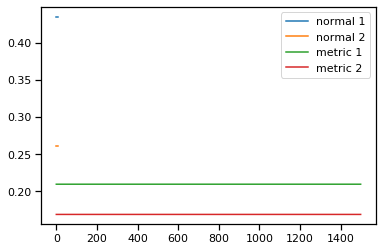

In [149]:
normal_step_size = chain_output_normal.trace[2]
metric_step_size = chain_output_metric.trace[2]

plt.plot(normal_step_size[:, 0, 0], label='normal 1')
plt.plot(normal_step_size[:, 1, 0], label='normal 2')

plt.plot(metric_step_size[:, 0, 0], label='metric 1')
plt.plot(metric_step_size[:, 1, 0], label='metric 2')
plt.legend()

In [108]:
# plt.plot(is_accepted[:, 0], linestyle='', marker='+')
# plt.plot(is_accepted[:, 1], linestyle='', marker='+')

In [109]:
# def running_average(x, N=10):
#     return np.convolve(x, np.ones((N,))/N, mode='valid')

In [110]:
# plt.plot(running_average(is_accepted[:, 0]))
# plt.plot(running_average(is_accepted[:, 1]))

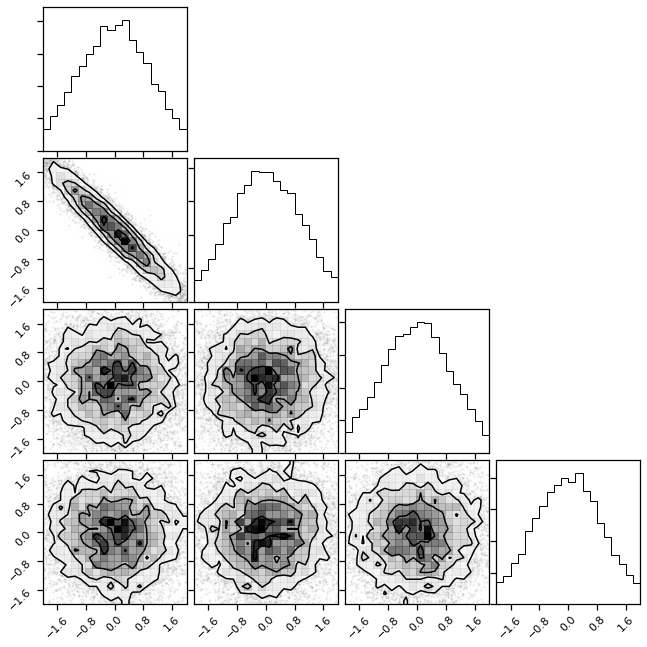

In [111]:
_ = corner.corner(exact_samples.numpy().reshape(-1, dim), range=[[-2, 2] for _ in range(dim)])

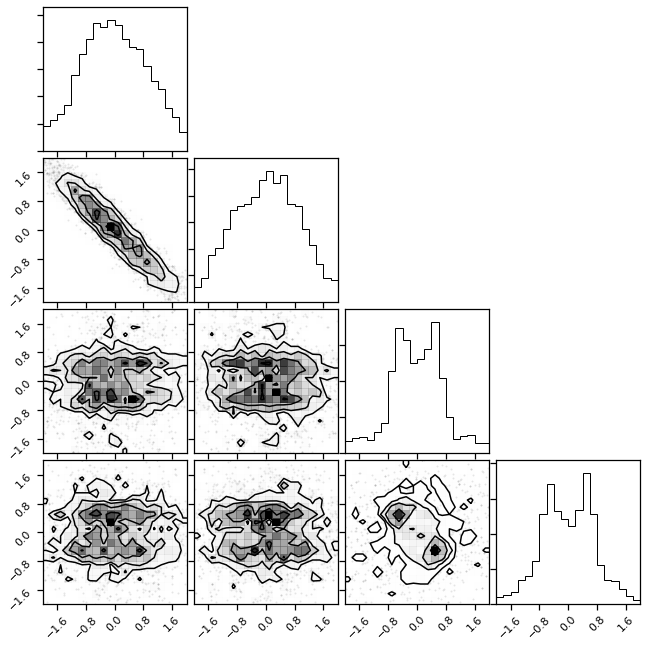

In [112]:
# type(chain_output)
samples = chain_output_normal.all_states
samples = samples.numpy()
reshaped_normal = samples.squeeze().reshape(-1, dim)
_ = corner.corner(reshaped_normal, range=[[-2, 2] for _ in range(dim)])

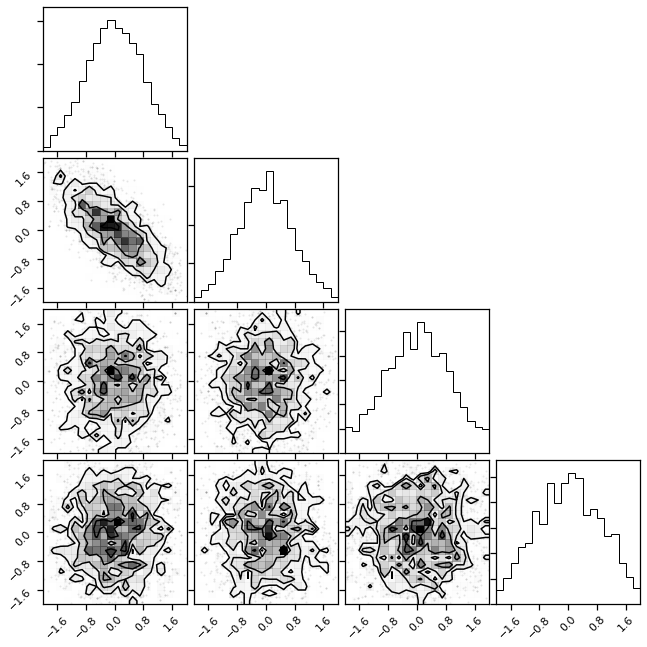

In [113]:
# type(chain_output)
samples = chain_output_metric.all_states
samples = samples.numpy()
metric_raw = samples.squeeze().reshape(-1, dim)
_ = corner.corner(metric_raw, range=[[-2, 2] for _ in range(dim)])

In [114]:
def safe_sqrt(x):
    sqrt = np.sqrt(np.abs(x))
    sqrt[x < 0.] = sqrt[x < 0.] * -1
    return sqrt
    

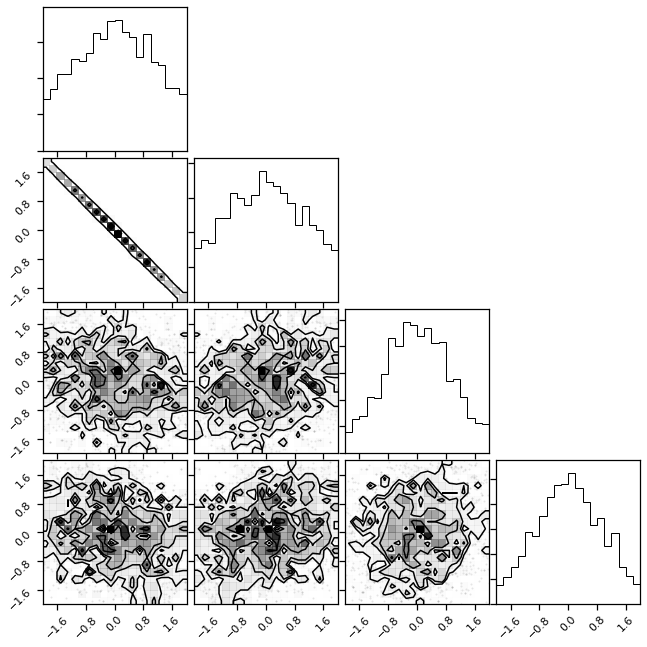

In [115]:
samples_prime = np.matmul(samples, safe_sqrt(covariances[0]))  # need to transform the parameters by the inverse metric to get back to real params
_ = corner.corner(samples_prime.reshape(-1, dim), range=[[-2, 2] for _ in range(dim)])

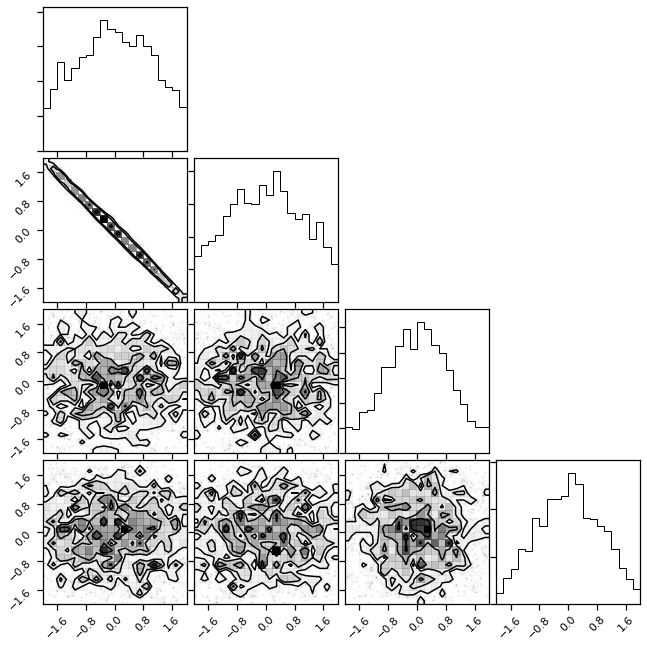

In [116]:
samples_prime = np.matmul(samples, covariances[0])  # need to transform the parameters by the inverse metric to get back to real params
samples_prime.shape
_ = corner.corner(samples_prime.reshape(-1, dim), range=[[-2, 2] for _ in range(dim)])

In [117]:
exact_samples.shape

TensorShape([10000, 1, 4])

samples_prime_reshaped = samples_prime.reshape(-1, 3)

In [108]:
exact_samples.numpy().shape

(100000, 3)

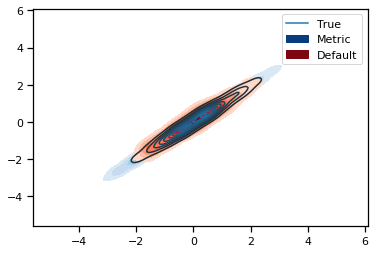

In [116]:
fig, ax = plt.subplots()
bw = 0.2
sns.kdeplot(data=exact_samples.numpy()[:num_results, 0], data2=exact_samples.numpy()[:num_results, 0], shade=False, shade_lowest=False, ax=ax, label='True', bw=bw)
sns.kdeplot(data=samples_prime_reshaped[:, 0], data2=samples_prime_reshaped[:, 1], shade=True, shade_lowest=False, cmap='Blues', ax=ax, label='Metric', bw=bw)
sns.kdeplot(data=reshaped_normal[:, 0], data2=reshaped_normal[:, 1], shade=True, shade_lowest=False, cmap='Reds', ax=ax, label='Default', bw=bw)
ax.legend()

In [46]:
# for n in range(len(initial_state)):
#     plt.hist(samples[:, n], alpha=0.4, density=True)
# x = np.linspace(-9, 9)
# plt.plot(x, dist.prob(x).numpy())